In [1]:
import keras
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Conv2D, Dropout, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import decode_predictions, preprocess_input
from scipy import spatial
from matplotlib.patches import Rectangle
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import cv2
%matplotlib inline

Using TensorFlow backend.
/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a release (2.7.7+) that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,


In [2]:
#full image view and full image as array
img = image.load_img("ny_resized.jpg")
full_img = image.img_to_array(img)

Functions

In [3]:
#return distance between vector points
def vector_dist(v1, v2):
    return spatial.distance.cdist(v1, v2)

In [4]:
#return model
def get_model():
    res_model = ResNet50(include_top=False, weights = 'imagenet', input_shape = (224, 224, 3))
    #res_model = ResNet50(include_top=False, weights = 'imagenet', input_shape = (224, 224, 3), pooling = 'max')
    max_pool = MaxPooling2D()(res_model.output)
    max_pool2 = MaxPooling2D()(max_pool)
    flat_1 = Flatten()(max_pool2)
    #flat_1 = Flatten()(max_pool)
    model = Model(inputs = res_model.inputs, outputs = flat_1)
    model.compile(optimizer = 'rmsprop', loss = "categorical_crossentropy", metrics = ['accuracy'])
    return model

In [5]:
#return prediction
def get_pred(t_img):
    t_test = image.img_to_array(t_img)
    t_test = np.expand_dims(t_test, axis=0)
    t_test = preprocess_input(t_test)
    return model.predict(t_test)

In [6]:
#return value from x/y index
def return_xy(randx, randy, idx):
    t_x = randx[idx : idx + 1]
    t_y = randy[idx : idx + 1]
    return int(t_x), int(t_y)

In [7]:
#return subarray from full image
def get_img_slice(t_img, x, y, model_width):
    t_array = t_img[y + half_est_location: y + model_width + est_location - half_est_location, x + half_est_location: x + model_width + est_location - half_est_location, :]
    return t_array

In [8]:
#random search returns x, y coordinates
def random_search(img, x_start, x_finish, y_start, y_finish):
    num_samples = 500
    rand_x = np.random.randint(x_start, x_finish, num_samples)
    rand_y = np.random.randint(y_start, y_finish, num_samples)
    dist_array = []
    for i in range(len(rand_x)):
        test_slice = get_img_slice(img, rand_x[i], rand_y[i], model_width)
        test_img = image.array_to_img(test_slice)
        dist_array.append(vector_dist(goal_pred, get_pred(test_img))[0][0])
    return return_xy(rand_x, rand_y, np.argmin(dist_array))

In [9]:
def narrow_search(img, x_start, x_finish, y_start, y_finish):
    dist_array = []
    t_i = []
    t_j = []
    for i in range(x_start, x_finish):
        for j in range(y_start, y_finish):
            test_slice = get_img_slice(img, i, j, model_width)
            test_img = image.array_to_img(test_slice)
            dist_array.append(vector_dist(goal_pred, get_pred(test_img))[0][0])
            t_i.append(i)
            t_j.append(j)
    
    return t_i[np.argmin(dist_array): np.argmin(dist_array) + 1][0], t_j[np.argmin(dist_array): np.argmin(dist_array) + 1][0] 

In [10]:
#runs random search twice (narrowing window), then runs narrow search 
def target_search():
    x, y = random_search(tee_ny, rand_x_start, rand_x_fin, rand_y_start, rand_y_fin)
    x, y = random_search(tee_ny, x - 50, x + 50, y - 50, y + 50)
    x, y = narrow_search(tee_ny, x - 5, x + 6, y - 5, y + 6)
    return x, y

In [11]:
#in middle pixel, returns starting and ending slice points
def start_lines(pix_x, pix_y):
    x_start = pix_x - 100 - 112 
    x_finish = pix_x + 100 + 112
    y_start = pix_y - 100 - 112 
    y_finish = pix_y + 100 + 112
    return x_start, x_finish, y_start, y_finish

Definitions

In [12]:
model = get_model()

/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [13]:
model_width = 224
half_model_width = int(224 * .5)
est_location = 200
half_est_location = int(est_location * .5)

In [14]:
#actual locations, pix locations are visual points of interest
pix_x, pix_y = 639, 750
#pix_x, pix_y = 465, 635
#pix_x, pix_y = 1211, 1038
#actual target start
x_start_num, x_finish_num, y_start_num, y_finish_num= start_lines(pix_x, pix_y)

In [15]:
#add random estimate to pix location +- 50pix
pix_x_neg, pix_x_pos = pix_x - half_est_location, pix_x + half_est_location
pix_y_neg, pix_y_pos = pix_y - half_est_location, pix_y + half_est_location
pix_x_est, pix_y_est = np.random.randint(pix_x_neg, pix_x_pos),np.random.randint(pix_y_neg, pix_y_pos)
rand_x_start, rand_x_fin, rand_y_start, rand_y_fin = start_lines(pix_x_est, pix_y_est)

In [16]:
#display full image with tee_ny (arbitrary) area selected
#plt.figure(figsize = (15,15))
#plt.gca().add_patch(Rectangle((5000, 8250), 2000, 2000, linewidth = 3, edgecolor = 'r', facecolor = 'none'));
#plt.imshow(np.asarray(img));

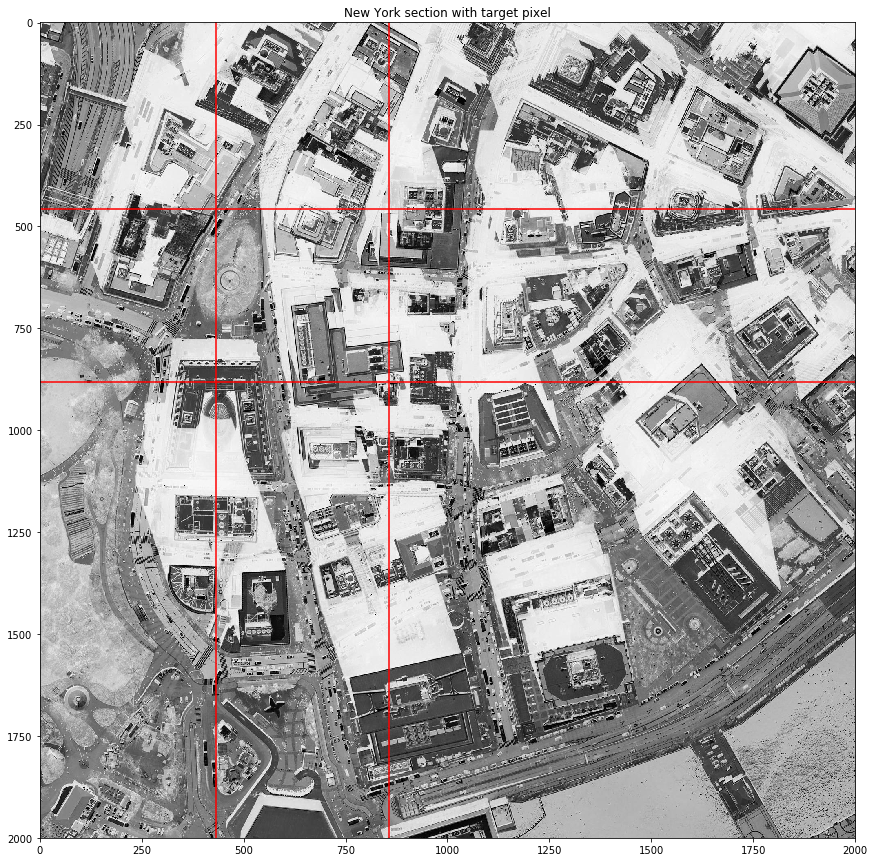

In [29]:
#return subarray (tee_ny) from full image, arbitrarily chosen
tee_ny = full_img[8250: 10250, 5000:  7000, :]
tee_ny_img = image.array_to_img(tee_ny)
plt.figure(figsize = (15,15))
plt.axvline(x= rand_x_start, color= 'red')
plt.axvline(x= rand_x_fin, color= 'red')
plt.axhline(y= rand_y_start, color= 'red')
plt.axhline(y= rand_y_fin, color= 'red')
plt.title('New York section with target pixel')
plt.imshow(tee_ny);

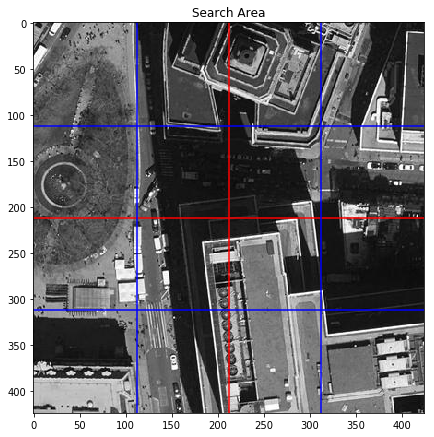

In [18]:
search_img = tee_ny[rand_y_start : rand_y_fin, rand_x_start: rand_x_fin, :]
search_img = image.array_to_img(search_img)
plt.figure(figsize = (7,10))
plt.title('Search Area')
plt.axvline(x = 212, color = 'red')
plt.axhline(y = 212, color = 'red')
plt.axvline(x = 212 - 100, color = 'blue')
plt.axhline(y = 212 + 100, color = 'blue')
plt.axvline(x = 212 + 100, color = 'blue')
plt.axhline(y = 212 - 100, color = 'blue')
#plt.axis('off')
plt.imshow(search_img);

(224, 224, 3)


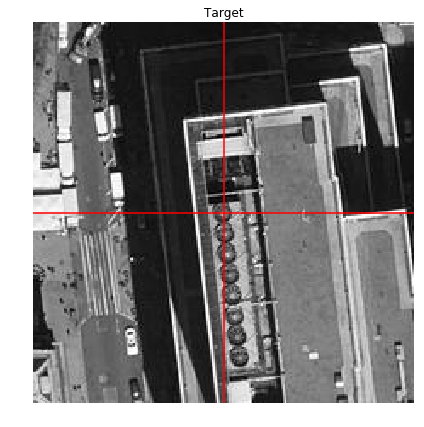

In [19]:
#Target Image and target to predict
x_img_array = get_img_slice(image.img_to_array(tee_ny), x_start_num, y_start_num, model_width)
print(x_img_array.shape)
x_img = image.array_to_img(x_img_array)
goal_pred = get_pred(x_img)
plt.figure(figsize = (7,7))
plt.title('Target')
plt.axvline(x= model_width * .5, color= 'red')
plt.axhline(y= model_width * .5, color= 'red')
plt.axis('off')
plt.imshow(x_img);

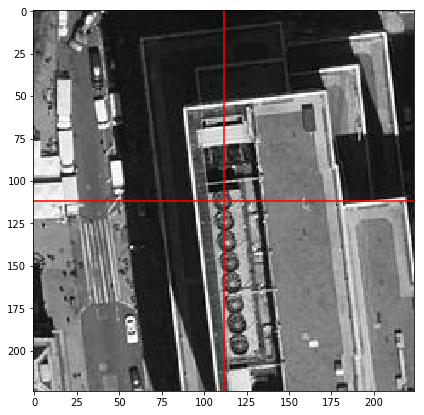

In [20]:
x, y = target_search() 
z_img = get_img_slice(tee_ny, x, y, model_width)
z_img = image.array_to_img(z_img)
plt.figure(figsize = (7,7))
plt.axvline(x = model_width * .5, color = 'red')
plt.axhline(y = model_width * .5, color = 'red')
plt.imshow(z_img);

In [21]:
x + half_model_width + half_est_location, y + half_model_width + half_est_location

(639, 750)

In [22]:
pix_x, pix_y

(639, 750)

In [23]:
#plt.scatter(range(len(rand_x)), dist_array3, color = 'lightblue');

In [24]:
#plt.hist(dist_array3, color = 'lightblue');